In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import geopandas as gpd

df = pd.read_csv("../CSV/2010-2021.csv")

# create grouping of data using specified column
groupby_borough = df.groupby(['BOROUGH'])

# creates a copy of specified entry within the column group
borough = groupby_borough.get_group(('STATEN ISLAND',)).copy()
borough.drop('LOWEST SALE PRICE', axis=1, inplace=True)
borough.drop('HIGHEST SALE PRICE', axis=1, inplace=True)

# group further by home type
groupby_home = borough.groupby(['TYPE OF HOME'])
two = groupby_home.get_group(('02 TWO FAMILY HOMES',)).copy()

# set up to do regession 
hood_names_two = two['NEIGHBORHOOD'].unique()
groupby_hood = two.groupby(['NEIGHBORHOOD'])
# addresses small samples
small_sample = ["TODT HILL", "BLOOMFIELD", "FRESH KILLS"] 

# prediction model
dic_two = {}
for h in hood_names_two:
    temp = groupby_hood.get_group((h,)).copy()
    # print(h)
    if h in small_sample:
        dic_two[h] = temp['AVERAGE SALE PRICE'].item()
    else:
        X = temp[['YEAR', 'MEDIAN SALE PRICE', 'NUMBER OF SALES']]
        y = temp['AVERAGE SALE PRICE']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        dic_two[h] = y_pred[0]

# map of neighborhood
shape = gpd.read_file("../nynta2020_24b/nynta2020.shp")

# removes all borough that isn't the working set
to_drop = shape[shape["BoroName"] != "Staten Island"].index 
shape.drop(to_drop, inplace=True) 

# removes all other columns that we don't really care for
shape = shape.drop(columns=["BoroCode", "BoroName", "CountyFIPS", "NTA2020", "NTAAbbrev", "NTAType", "CDTA2020", "Shape_Leng", "Shape_Area", "CDTAName"])

hood_names_two 

array(['ANNADALE', 'ARDEN HEIGHTS', 'ARROCHAR', 'ARROCHAR-SHORE ACRES',
       'BULLS HEAD', 'CASTLETON CORNERS', 'CLOVE LAKES', 'CONCORD',
       'DONGAN HILLS', 'DONGAN HILLS-COLONY', 'ELTINGVILLE',
       'EMERSON HILL', 'GRANT CITY', 'GRASMERE', 'GREAT KILLS',
       'GREAT KILLS-BAY TERRACE', 'GRYMES HILL', 'HUGUENOT', 'LIVINGSTON',
       'MANOR HEIGHTS', 'MARINERS HARBOR', 'MIDLAND BEACH',
       'NEW BRIGHTON', 'NEW DORP', 'NEW DORP-BEACH', 'NEW DORP-HEIGHTS',
       'NEW SPRINGVILLE', 'OAKWOOD', 'OAKWOOD-BEACH', 'PLEASANT PLAINS',
       'PORT IVORY', 'PORT RICHMOND', 'PRINCES BAY', 'RICHMONDTOWN',
       'ROSEBANK', 'ROSSVILLE', 'ROSSVILLE-CHARLESTON',
       'ROSSVILLE-RICHMOND VALLEY', 'SILVER LAKE', 'SOUTH BEACH',
       'STAPLETON', 'STATEN ISLAND-UNKNOWN', 'SUNNYSIDE', 'TOMPKINSVILLE',
       'TOTTENVILLE', 'TRAVIS', 'WEST NEW BRIGHTON', 'WESTERLEIGH',
       'WILLOWBROOK', 'WOODROW', 'DONGAN HILLS-OLD TOWN',
       'STAPLETON-CLIFTON', 'NEW BRIGHTON-ST. GEORGE',
       

In [10]:
pairs = {
    'St. George-New Brighton': 'NEW BRIGHTON-ST. GEORGE',
    'Tompkinsville-Stapleton-Clifton-Fox Hills': 'STAPLETON-CLIFTON',
    'Rosebank-Shore Acres-Park Hill': 'ROSEBANK',
    'West New Brighton-Silver Lake-Grymes Hill': 'WEST NEW BRIGHTON',
    'Westerleigh-Castleton Corners': 'CASTLETON CORNERS',
    'Port Richmond': 'PORT RICHMOND',
    "Mariner's Harbor-Arlington-Graniteville": 'MARINERS HARBOR',
    'Snug Harbor': None,
    'Grasmere-Arrochar-South Beach-Dongan Hills': 'ARROCHAR-SHORE ACRES',
    'New Dorp-Midland Beach': 'NEW DORP',
    'Todt Hill-Emerson Hill-Lighthouse Hill-Manor Heights': 'TODT HILL',
    'New Springville-Willowbrook-Bulls Head-Travis': 'TOTTENVILLE',
    'Freshkills Park (North)': 'FRESH KILLS',
    'Oakwood-Richmondtown': 'RICHMONDTOWN',
    'Great Kills-Eltingville': 'GREAT KILLS',
    'Arden Heights-Rossville': 'ROSSVILLE',
    "Annadale-Huguenot-Prince's Bay-Woodrow": 'ANNADALE',
    'Tottenville-Charleston': 'TOTTENVILLE',
    'Freshkills Park (South)': 'FRESH KILLS',
    'Fort Wadsworth': None,
    'Hoffman & Swinburne Islands': None,
    'Miller Field': None,
    'Great Kills Park': 'GREAT KILLS'
}


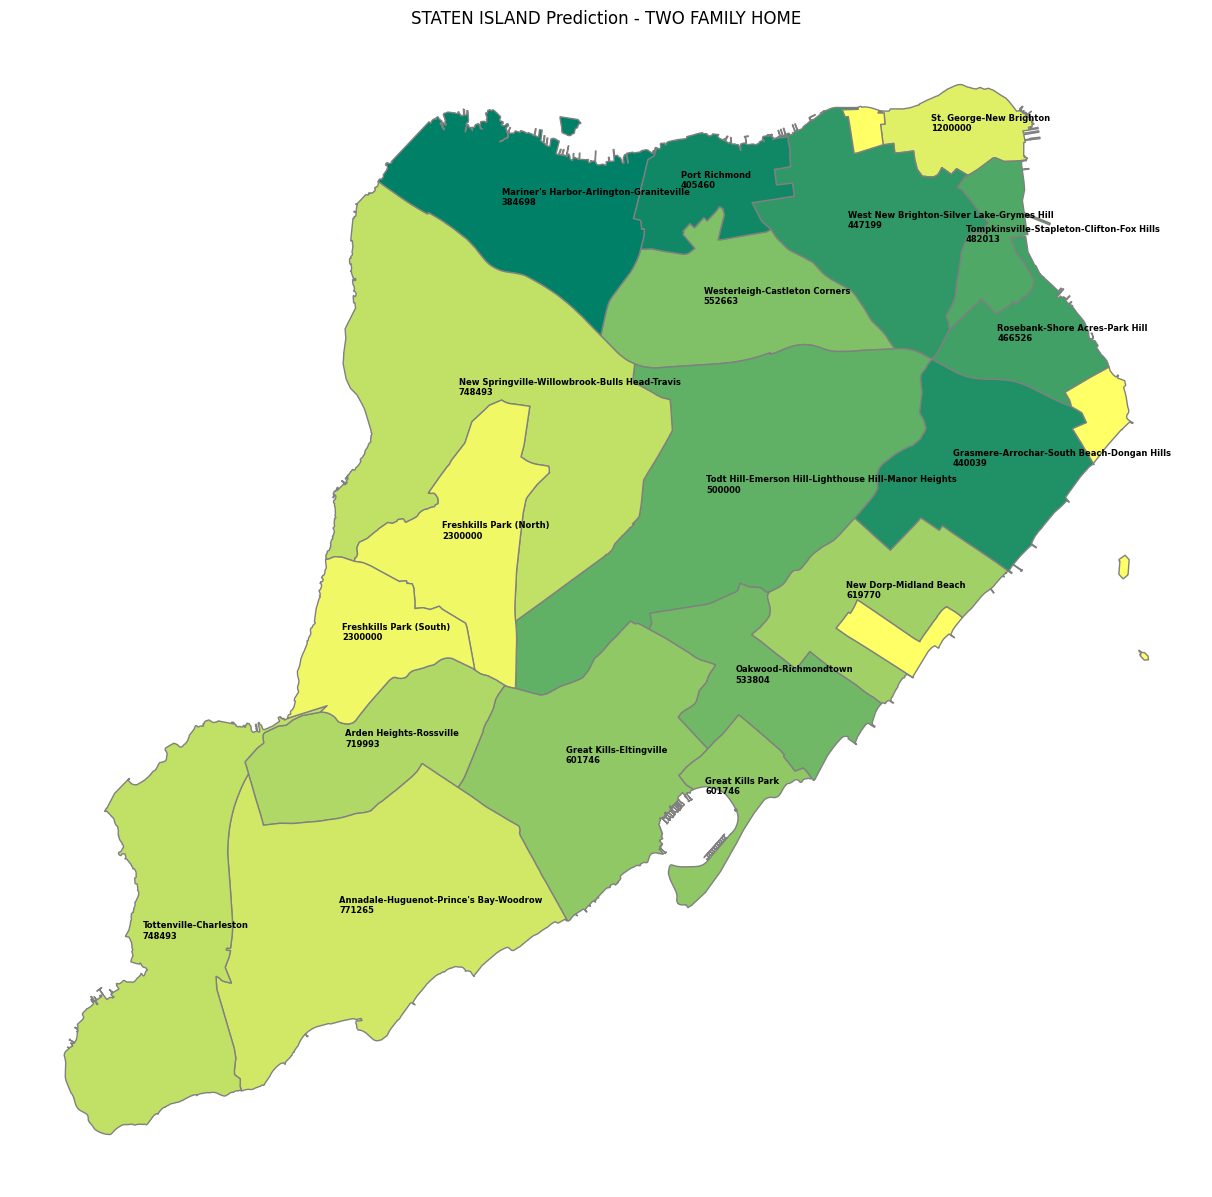

In [12]:
import matplotlib.pyplot as plt

# map of neighborhood
shape = gpd.read_file("../nynta2020_24b/nynta2020.shp")

# removes all borough that isn't the working set
to_drop = shape[shape["BoroName"] != "Staten Island"].index 
shape.drop(to_drop, inplace=True) 

# removes all other columns that we don't really care for
shape = shape.drop(columns=["BoroCode", "BoroName", "CountyFIPS", "NTA2020", "NTAAbbrev", "NTAType", "CDTA2020", "Shape_Leng", "Shape_Area", "CDTAName"])

shape['sales'] = "-"

# adding sales data to overall df
for i, row in shape.iterrows():
    holder = pairs[row['NTAName']]
    if holder:
        if isinstance(holder, list):
            sum = 0
            for e in holder:
                sum += dic_two[e]
            shape.at[i, 'sales'] = int(sum/len(holder))
        else:
            shape.at[i, 'sales'] = int(dic_two[holder])

# sets map settings
shape_map = shape.plot(column='sales', k=8, cmap='summer', figsize=(30,15), linewidth=1, edgecolor='0.5')
# adds labels to map
for i, row in shape.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['sales'] != "-" :
        label = row['NTAName'] + "\n" + str(row['sales'])
        shape_map.annotate(label, xy=(x, y), xytext=(-20, 0), color="black", textcoords="offset points", fontsize=6, weight="bold")
# draws the map
shape_map.set(title="STATEN ISLAND Prediction - TWO FAMILY HOME")
shape_map.set_axis_off()